<a href="https://colab.research.google.com/github/Hashnroll/pygame_game/blob/master/TuhtaevAshurbek_kaggle_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
# !pip install catboost

#Импортируем нужные библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor

#Чтение данных

In [ ]:
train_df = pd.read_csv('./train.csv', index_col='id')
test_df = pd.read_csv('./test.csv', index_col='id')
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (70133, 31)
Test shape: (17534, 30)


#Посмотрим на датасет

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70133 entries, 45673 to 62175
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   priceValue                  70133 non-null  int64  
 1   details                     70133 non-null  object 
 2   location                    70133 non-null  object 
 3   galleryImagesCount          70133 non-null  int64  
 4   hasVideos                   70133 non-null  bool   
 5   isReported                  70133 non-null  bool   
 6   isVerifiedProAgency         70133 non-null  bool   
 7   isShownLowQualityIndicator  70133 non-null  bool   
 8   isPremium                   70133 non-null  bool   
 9   station                     70133 non-null  object 
 10  closestStations             70133 non-null  object 
 11  rooms                       70133 non-null  object 
 12  floorArea                   70133 non-null  object 
 13  floor                      

In [ ]:
train_df.head()

,priceValue,details,location,galleryImagesCount,hasVideos,isReported,isVerifiedProAgency,isShownLowQualityIndicator,isPremium,station,...,cityId,adminDistrictId,districtId,metroId,roomsOrdinal,isStudio,isFreePlan,apartmentSaleType,developmentId,roadId
id,,,,,,,,,,,,,,,,,,,,,
45673,14630000,57.5 м²,"{'longitude': 37.3802, 'latitude': 55.81002}",6,False,False,False,False,False,"{'id': 231, 'stationType': 'Metro', 'name': 'М...",...,3584,10.0,574.0,231.0,1.0,False,False,New,1.034510e+09,NaN
27729,15284500,35 м²,"{'longitude': 37.65031, 'latitude': 55.84894}",5,False,False,False,False,False,"{'id': 119, 'stationType': 'Metro', 'name': 'С...",...,3584,5.0,504.0,119.0,NaN,True,False,New,1.037459e+09,NaN
72599,8400000,21.5 м²,"{'longitude': 37.599337, 'latitude': 55.772294}",7,True,False,False,False,False,"{'id': 78, 'stationType': 'Metro', 'name': 'Ма...",...,3584,3.0,537.0,78.0,NaN,True,False,Resale,NaN,NaN
46172,81000000,133 м²,"{'longitude': 37.488035, 'latitude': 55.69624}",8,False,False,False,False,False,"{'id': 350, 'stationType': 'Metro', 'name': 'Р...",...,3584,10.0,623.0,350.0,4.0,False,False,Resale,NaN,NaN
17852,12300000,41.4 м²,"{'longitude': 37.437568, 'latitude': 55.722527}",16,False,False,False,False,False,"{'id': 694, 'stationType': 'Railway', 'name': ...",...,3584,10.0,539.0,70.0,2.0,False,False,Resale,NaN,NaN


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17534 entries, 62321 to 66286
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   isFreePlan                  17534 non-null  bool   
 1   isShownLowQualityIndicator  17534 non-null  bool   
 2   isReported                  17534 non-null  bool   
 3   adminDistrictId             15915 non-null  float64
 4   roadId                      13 non-null     float64
 5   districtId                  15915 non-null  float64
 6   rooms                       17534 non-null  object 
 7   isVerifiedProAgency         17534 non-null  bool   
 8   isPremium                   17534 non-null  bool   
 9   details                     17534 non-null  object 
 10  regionId                    17534 non-null  int64  
 11  developmentId               8945 non-null   float64
 12  agencyName                  17534 non-null  object 
 13  galleryImagesCount         

In [ ]:
test_df.head()

,isFreePlan,isShownLowQualityIndicator,isReported,adminDistrictId,roadId,districtId,rooms,isVerifiedProAgency,isPremium,details,...,closestStations,apartmentSaleType,station,roomsOrdinal,isStudio,metroId,hasVideos,propertyType,floorInt,floorArea
id,,,,,,,,,,,,,,,,,,,,,
62321,False,False,False,8.0,NaN,562.0,1,False,False,38.6 м²,...,"[{'id': 540, 'stationType': 'Railway', 'distan...",Resale,"{'id': 540, 'stationType': 'Railway', 'name': ...",1.0,False,58.0,False,Apartment,14,38.6 м²
13154,False,False,False,10.0,NaN,523.0,3,False,False,125.2 м²,...,"[{'id': 319, 'stationType': 'Metro', 'distance...",Resale,"{'id': 319, 'stationType': 'Metro', 'name': 'Т...",3.0,False,319.0,False,Apartment,20,125.2 м²
26935,False,False,False,10.0,NaN,522.0,1,False,False,53.1 м²,...,"[{'id': 764, 'stationType': 'Railway', 'distan...",New,"{'id': 764, 'stationType': 'Railway', 'name': ...",1.0,False,NaN,False,Apartment,10,53.1 м²
39371,False,False,False,3.0,NaN,509.0,3,False,False,106 м²,...,"[{'id': 56, 'stationType': 'Metro', 'distance'...",Resale,"{'id': 56, 'stationType': 'Metro', 'name': 'Ки...",3.0,False,153.0,False,Apartment,2,106 м²
47540,False,False,False,4.0,NaN,581.0,1,False,False,15.5 м²,...,"[{'id': 114, 'stationType': 'Metro', 'distance...",Resale,"{'id': 114, 'stationType': 'Metro', 'name': 'Р...",1.0,False,NaN,False,Apartment,1,15.5 м²


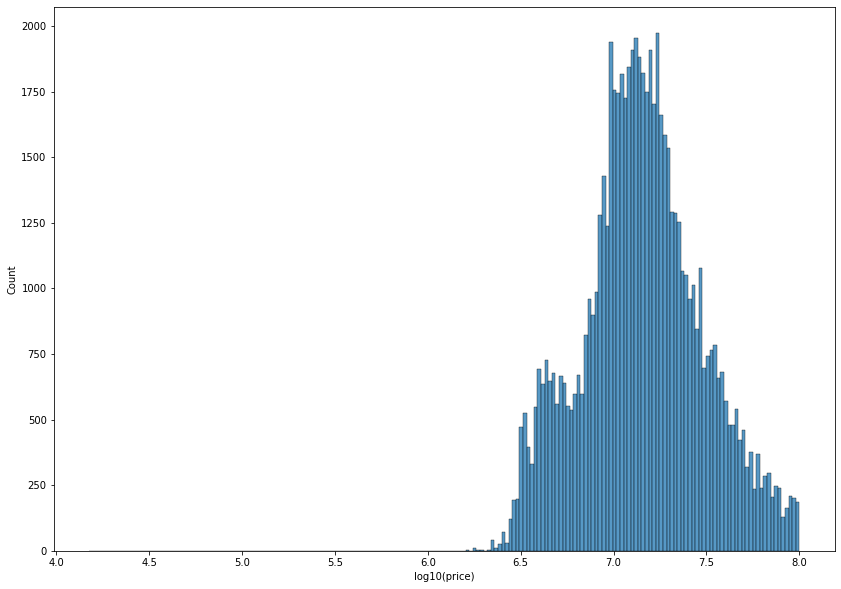

In [ ]:
plt.figure(figsize=(14,10))
sns.histplot(np.log10(train_df['priceValue']).rename('log10(price)'))
plt.show()

#Обработаем датасет

Удалим дублирующие колонки (площадь квартиры)

In [ ]:
print(train_df[['floorAreaCalculated', 'floorArea', 'details']].head(3))
print(test_df[['floorAreaCalculated', 'floorArea', 'details']].head(3))

       floorAreaCalculated floorArea  details
id                                           
45673                 57.5   57.5 м²  57.5 м²
27729                 35.0     35 м²    35 м²
72599                 21.5   21.5 м²  21.5 м²
       floorAreaCalculated floorArea   details
id                                            
62321                 38.6   38.6 м²   38.6 м²
13154                125.2  125.2 м²  125.2 м²
26935                 53.1   53.1 м²   53.1 м²


In [ ]:
train_df = train_df.drop(columns=['floorArea', 'details'])
test_df = test_df.drop(columns=['floorArea', 'details'])

Удалим колонку rooms, т.к. она дублирует roomsOrdinal и isStudio

In [ ]:
train_df[['rooms', 'roomsOrdinal', 'isStudio']].head()

,rooms,roomsOrdinal,isStudio
id,,,
45673,1,1.0,False
27729,Студия,NaN,True
72599,Студия,NaN,True
46172,4,4.0,False
17852,2,2.0,False


In [ ]:
train_df[train_df['isStudio'] == True]['priceValue'].describe().map('{:.2f}'.format)

count       15704.00
mean      6618536.77
std       3889315.14
min       1600000.00
25%       4200000.00
50%       5700000.00
75%       8000000.00
max      95000000.00
Name: priceValue, dtype: object

In [ ]:
train_df[train_df['isStudio'] == False]['priceValue'].describe().map('{:.2f}'.format)

count        54429.00
mean      22470417.69
std       16458265.27
min          15000.00
25%       11996710.00
50%       16900000.00
75%       26626614.00
max      100000000.00
Name: priceValue, dtype: object

In [ ]:
train_df = train_df.drop(columns=['rooms'])
train_df['roomsOrdinal'] = train_df['roomsOrdinal'].fillna(1).astype(int)

test_df = test_df.drop(columns=['rooms'])
test_df['roomsOrdinal'] = test_df['roomsOrdinal'].fillna(1).astype(int)

Добавим новую колонку - количество этажей в здании

In [ ]:
train_df[['floor', 'floorInt']].head()

,floor,floorInt
id,,
45673,5/10,5
27729,41/53,41
72599,1/5,1
46172,48/52,48
17852,5/5,5


In [ ]:
train_df['totalFloors'] = train_df['floor'].apply(lambda x: int(x.split('/')[-1]))
test_df['totalFloors'] = test_df['floor'].apply(lambda x: int(x.split('/')[-1]))

In [ ]:
train_df = train_df.drop(columns=['floor'])
test_df = test_df.drop(columns=['floor'])

In [ ]:
train_df[['floorInt', 'totalFloors']].head()

,floorInt,totalFloors
id,,
45673,5,10
27729,41,53
72599,1,5
46172,48,52
17852,5,5


Удалим roadId, слишком много пропущенных значений

In [ ]:
train_df = train_df.drop(columns=['roadId'])
test_df = test_df.drop(columns=['roadId'])

Создадим новые признаки из closestStations

In [ ]:
train_df['closestStations'] = train_df['closestStations'].apply(lambda s: json.loads(s.replace("'", "\"")))
test_df['closestStations'] = test_df['closestStations'].apply(lambda s: json.loads(s.replace("'", "\"")))

In [ ]:
print(train_df['closestStations'].apply(lambda d: d[0]['distance']).max())
print(test_df['closestStations'].apply(lambda d: d[0]['distance']).max())

4999
4987


In [ ]:
train_df['station'] = train_df['station'].apply(lambda s: json.loads(s.replace("'", "\"")))
test_df['station'] = test_df['station'].apply(lambda s: json.loads(s.replace("'", "\"")))

Станция считается близлежащей, если расстояние до нее меньше 5 км

In [ ]:
train_df['numberStations'] = train_df['closestStations'].map(lambda d: len(d))
test_df['numberStations'] = test_df['closestStations'].map(lambda d: len(d))

In [ ]:
train_df['closestStationId'] = train_df['closestStations'].map(lambda d: d[0]['id'])
test_df['closestStationId'] = test_df['closestStations'].map(lambda d: d[0]['id'])

train_df = train_df.drop(columns=['metroId'])
test_df = test_df.drop(columns=['metroId'])

In [ ]:
train_df['closestStationType'] = train_df['closestStations'].map(lambda d: d[0]['stationType'])
test_df['closestStationType'] = test_df['closestStations'].map(lambda d: d[0]['stationType'])

In [ ]:
train_df['closestStationDistance'] = train_df['closestStations'].map(lambda d: d[0]['distance'])
test_df['closestStationDistance'] = test_df['closestStations'].map(lambda d: d[0]['distance'])

In [ ]:
train_df['station'].iloc[0]

{'distance': 1.581,
 'distanceString': '1.6 км',
 'id': 231,
 'lineColors': ['#0078BF'],
 'name': 'Мякинино',
 'stationType': 'Metro'}

In [ ]:
train_df['lineColors'] = train_df['station'].map(lambda d: d['lineColors'])
test_df['lineColors'] = test_df['station'].map(lambda d: d['lineColors'])

In [ ]:
train_df['linesNumber'] = train_df['station'].map(lambda d: len(d['lineColors']))
test_df['linesNumber'] = test_df['station'].map(lambda d: len(d['lineColors']))

In [ ]:
lineColors = []
for row in train_df['lineColors']:
  for color in row:
    if color not in lineColors:
      lineColors.append(color)

In [ ]:
for lineColor in lineColors:
  train_df[lineColor] = train_df['lineColors'].apply(lambda l: lineColor in l).astype(int)
  test_df[lineColor] = test_df['lineColors'].apply(lambda l: lineColor in l).astype(int)

In [ ]:
train_df = train_df.drop(columns=['lineColors', 'station', 'closestStations'])
test_df = test_df.drop(columns=['lineColors', 'station', 'closestStations'])

Удалим признаки, для которых только одно уникальное значение

In [ ]:
print(f"Уникальные города в train: {train_df['cityId'].unique()}")
print(f"Уникальные города в test: {test_df['cityId'].unique()}")

Уникальные города в train: [3584]
Уникальные города в test: [3584]


In [ ]:
print(train_df['itemType'].unique())
print(test_df['itemType'].unique())

['Sale']
['Sale']


In [ ]:
print(train_df['propertyType'].unique())
print(test_df['propertyType'].unique())

['Apartment']
['Apartment']


In [ ]:
print(train_df['regionId'].unique())
print(test_df['regionId'].unique())

[81]
[81]


In [ ]:
print(train_df['apartmentSaleType'].unique())
print(test_df['apartmentSaleType'].unique())

['New' 'Resale']
['Resale' 'New']


In [ ]:
train_df = train_df.drop(columns=['cityId', 'itemType', 'propertyType', 'regionId'])
test_df = test_df.drop(columns=['cityId', 'itemType', 'propertyType', 'regionId'])

Удалим колонку agencyName, т.к. есть agencyId

In [ ]:
train_df = train_df.drop(columns=['agencyName'])
test_df = test_df.drop(columns=['agencyName'])

Добавим признаки с координатами квартиры

In [ ]:
train_df.location.head()

id
45673       {'longitude': 37.3802, 'latitude': 55.81002}
27729      {'longitude': 37.65031, 'latitude': 55.84894}
72599    {'longitude': 37.599337, 'latitude': 55.772294}
46172     {'longitude': 37.488035, 'latitude': 55.69624}
17852    {'longitude': 37.437568, 'latitude': 55.722527}
Name: location, dtype: object

In [ ]:
train_df['location'] = train_df['location'].apply(lambda s: json.loads(s.replace("'", "\"")))
test_df['location'] = test_df['location'].apply(lambda s: json.loads(s.replace("'", "\"")))

In [ ]:
train_df['longitude'] = train_df['location'].map(lambda d: d['longitude'])
train_df['latitude'] = train_df['location'].map(lambda d: d['latitude'])
test_df['longitude'] = test_df['location'].map(lambda d: d['longitude'])
test_df['latitude'] = test_df['location'].map(lambda d: d['latitude'])

In [ ]:
train_df = train_df.drop(columns=['location'])
test_df = test_df.drop(columns=['location'])

Заполним пропуски в колонках

In [ ]:
train_df['adminDistrictId'] = train_df['adminDistrictId'].fillna(0).astype(int)
test_df['adminDistrictId'] = test_df['adminDistrictId'].fillna(0).astype(int)

In [ ]:
train_df['districtId'] = train_df['districtId'].fillna(0).astype(int)
test_df['districtId'] = test_df['districtId'].fillna(0).astype(int)

In [ ]:
train_df['developmentId'] = train_df['developmentId'].fillna(0).astype(int)
test_df['developmentId'] = test_df['developmentId'].fillna(0).astype(int)

Преобразуем bool в int

In [ ]:
for col in test_df.columns:
  if train_df[col].dtype == 'bool':
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70133 entries, 45673 to 62175
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   priceValue                  70133 non-null  int64  
 1   galleryImagesCount          70133 non-null  int64  
 2   hasVideos                   70133 non-null  int64  
 3   isReported                  70133 non-null  int64  
 4   isVerifiedProAgency         70133 non-null  int64  
 5   isShownLowQualityIndicator  70133 non-null  int64  
 6   isPremium                   70133 non-null  int64  
 7   agencyId                    70133 non-null  int64  
 8   floorInt                    70133 non-null  int64  
 9   floorAreaCalculated         70133 non-null  float64
 10  adminDistrictId             70133 non-null  int64  
 11  districtId                  70133 non-null  int64  
 12  roomsOrdinal                70133 non-null  int64  
 13  isStudio                   

# Обучение и валидация

In [ ]:
#категориальные признаки 
cat_columns = ['hasVideos',
'isReported',
'isVerifiedProAgency',
'isShownLowQualityIndicator',
'isPremium',
'agencyId',
'adminDistrictId',
'districtId',
'isStudio',
'isFreePlan',
'apartmentSaleType',
'developmentId',
'closestStationId',
'closestStationType']

cat_columns += lineColors

Удалим колонки, в которых остались пропуски

In [ ]:
train_df = train_df.dropna(axis=1, how='any')
test_df = test_df.dropna(axis=1, how='any')

Разделим выборку на обучающую и валидацию

In [ ]:
y = train_df['priceValue']
train_df = train_df.drop(columns=['priceValue'])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, test_size=0.3, random_state=17)

In [ ]:
eval_dataset = Pool(data=X_valid,
                    label=y_valid,
                    cat_features=cat_columns)

In [ ]:
model = CatBoostRegressor(iterations=50000, 
                          cat_features=cat_columns,
                          loss_function='RMSE',
                          l2_leaf_reg=10,
                          depth=7,
                          min_data_in_leaf=100,
                          task_type="GPU",
                          border_count=32)

model.fit(X_train, 
          y_train,
          early_stopping_rounds=500,
          eval_set=eval_dataset,
          verbose=True)

# Предсказание

In [ ]:
model = CatBoostRegressor(iterations=50000, 
                          cat_features=cat_columns,
                          loss_function='RMSE',
                          l2_leaf_reg=10,
                          depth=7,
                          min_data_in_leaf=100,
                          task_type="GPU")

model.fit(train_df, y, verbose=True)

In [ ]:
submit = pd.read_csv('./sample.csv', index_col=0)
submit['priceValue'] = model.predict(test_df)
submit.head()

,priceValue
id,
62321,1.272513e+07
13154,6.697015e+07
26935,1.967898e+07
39371,5.669555e+07
47540,4.733615e+06


In [ ]:
submit.to_csv('submit4.csv')